1(a) Import necessary libraries and dataset, compute the matrix of monthly returns

In [26]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
cp.installed_solvers()


['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']

In [28]:
#Load file and into dateframe
monthlyClosing_inSample = 'monthly_closings_2018_to_2020.csv'
monthlyClosing_outSample = 'monthly_closings_2021.csv'

df1 = pd.read_csv(monthlyClosing_inSample)
df2 = pd.read_csv(monthlyClosing_outSample)

#Remove date
price = df1.iloc[:,1:]
#Calculate monthly return as percent change of monthly closing values, reset indices 
ret = price.pct_change().iloc[1:,:]
ret.reset_index(inplace = True, drop = True)

price2021 = df2.iloc[:,1:]
#We want return for the whole year so only use first and last month
price2021_ = price2021.drop(price2021.index[1:11])
price2021_.reset_index(inplace = True, drop = True)

#Compute percent change
ret_2021 = price2021_.pct_change().iloc[1:,:]


1(b) Compute the covariance matrix and means of the percent change matrix

In [29]:
# Compute the covariance matrix of the percent change of prices
Q = ret.cov().to_numpy()

# Compute the mean for each column 
mu = np.array(np.mean(ret, axis = 0))

# Store number of features 
n = ret.shape[1] 

In [30]:
# Compute the covariance matrix of the percent change of prices
Q21 = ret_2021.cov().to_numpy()

# Compute the mean for each column 
mu21 = np.array(np.mean(ret_2021, axis = 0))

# Store number of features 
n21 = ret_2021.shape[1] 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9524: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1(c) Solve for the minimum variance portfolio

In [31]:
# Create optimization variable w1, 26 total variables 
w1 = cp.Variable(n)

# Form the problem , minimize
constraints1 = [sum(w1) == 1 , w1 >= 0]
prob1 = cp.Problem(cp.Minimize(cp.quad_form(w1, Q)) , [sum(w1) == 1 , w1 >= 0])

#Solve Problem
prob1.solve(verbose=False)

0.0009278939303461065

In [32]:
# matrix of allocations which offers the minimum variance 
w_minVar = w1.value #solution value: minimum variance 
w_minVar

array([ 2.34711076e-19,  5.74341943e-20,  8.04974643e-21,  8.47497298e-20,
        1.98801020e-20,  1.09424374e-20,  2.73065413e-20,  2.72299411e-19,
        5.54485957e-02,  1.08374508e-19,  8.96592846e-20,  6.59194971e-01,
       -6.72526425e-20,  2.57096580e-20,  1.76013193e-03,  8.87191244e-02,
        5.48842212e-02, -5.82451239e-20, -4.53773627e-19,  3.42087380e-20,
       -3.00374544e-20,  8.76648789e-20,  9.01180838e-02, -1.21197912e-21,
        4.98748717e-02])

In [33]:
#Compute the variance of the portfolio
var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar)) #variance
var_minVar

0.0009278939303461066

In [34]:
#Compute the return of the portfolio
ret_minVar = np.dot(mu, w_minVar) #expected return
ret_minVar

0.008653285914910979

1(d) Solve for the maximum return portfolio

In [35]:
# Create optimization variable w2, 26 total variables 
w2 = cp.Variable(n)

constraints2 = [sum(w2) == 1, w2 >= 0]
prob2 = cp.Problem(cp.Maximize(mu.T@w2), constraints2)
                   
# Solve the problem 
prob2.solve(verbose=False)

0.1021163469313111

In [36]:
# matrix of allocations which offers th
w_maxRet = w2.value #solution value: maximum expected return
w_maxRet

array([4.00446549e-11, 2.33109317e-11, 2.11897368e-11, 2.02514107e-11,
       2.13526338e-11, 2.10766681e-11, 2.36702200e-11, 2.30281295e-11,
       2.20156300e-11, 1.84127151e-11, 1.42266925e-11, 1.97676588e-11,
       1.08469522e-09, 1.88147929e-11, 2.37055006e-11, 1.85314364e-11,
       2.26815434e-11, 2.41212013e-11, 9.99999998e-01, 1.68558540e-11,
       8.78989931e-12, 2.30303345e-11, 2.19747289e-11, 2.02437383e-11,
       1.72961027e-11])

In [37]:
#Compute the variance of the portfolio
var_maxRet = np.dot(w_maxRet, np.dot(Q, w_maxRet)) #variance
var_maxRet

0.3397485196506799

In [38]:
#Compute the return of the portfolio
ret_maxRet = np.dot(mu, w_maxRet) #expected return
ret_maxRet

0.10211634693131112

1(e) Compute the classical Markowitz efficient frontier

In [39]:
#Create tareget ranges for portfolio returns
targetLen = 50
targetRet = np.linspace(ret_minVar,ret_maxRet,targetLen)


In [40]:
# Define optimization problem and compute one portfolio on efficient frontier
w = cp.Variable(n)
eps = cp.Parameter()

constraints3 = [mu.T@w >= eps,sum(w) == 1,w >= 0]
prob3 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)), constraints3)


In [41]:
# Compute efficient frontier
w_front_clas = []
var_front_clas = []
ret_front_clas = []
for epsilon in targetRet:
    eps.value = epsilon
    prob3.solve()
    w_front_clas.append(w.value)
    var_front_clas.append(np.dot(w.value, np.dot(Q, w.value)))
    ret_front_clas.append(np.dot(mu, w.value))

1(f) Compute the resampled efficient frontier

In [42]:
sample_size = ret.shape[0] 
repetition = 100

#set variables for storing resuts

#Usa a random seed so that results will be consistent 
np.random.seed(10)

w_front_re_list = []
Q_resample_list = []
mu_resample_list = []
var_minVar_list = []
ret_minVar_list = []
var_maxRet_list = []
ret_maxRet_list = []
var_frontC_list = []
ret_frontC_list = []
#Resample by taking n (sample size) draws from the original input
for i in range(repetition):
    
    
    #resample by drawing from the multivariate normal distribution with mu and Q
    x_resample = np.random.multivariate_normal(mu, Q, ret.shape[0])
    
    #Calculate the new mean vector (mu_resample) and new variance-covariance matrix (Q _resample) 
    #resampled mu and Q
    mu_resample = np.mean(x_resample, axis=0)
    Q_resample = np.cov(x_resample, rowvar=False)
    
    #Compute minimum variance
    # Create optimization variable w_resample1, 25 total variables 
    w_resample1 = cp.Variable(n)

    # Form the problem , minimize
    prob_resample1 = cp.Problem(cp.Minimize(cp.quad_form(w_resample1, Q_resample)) , [sum(w_resample1) == 1 , w_resample1 >= 0])

    #Solve Problem
    prob_resample1.solve(verbose=False)

    w_minVar_resample = w_resample1.value #solution value: minimum variance
    var_minVar_resample = np.dot(w_minVar_resample, np.dot(Q_resample, w_minVar_resample)) #variance
    ret_minVar_resample = np.dot(mu_resample, w_minVar_resample) #expected return

    #compute maximum expected return
    w_resample2 = cp.Variable(n)

    constraints_resample2 = [sum(w_resample2) == 1, w_resample2 >= 0]
    prob_resample2 = cp.Problem(cp.Maximize(mu_resample.T@w_resample2), constraints_resample2)

    # Solve the problem 
    prob_resample2.solve(verbose=False)

    w_maxRet_resample = w_resample2.value #solution value: maximum expected return
    var_maxRet_resample = np.dot(w_maxRet_resample, np.dot(Q_resample, w_maxRet_resample)) #variance
    ret_maxRet_resample = np.dot(mu_resample, w_maxRet_resample) #expected return

    #target return
    targetRet_re = np.linspace(ret_minVar_resample,ret_maxRet_resample,50)
    
    # Define optimization problem and compute one portfolio on efficient frontier
    w_re = cp.Variable(n)
    eps_re = cp.Parameter()
    
    constraints_resample3 = [mu_resample.T@w_re >= eps_re,sum(w_re) == 1,w_re >= 0]
    prob_resample3 = cp.Problem(cp.Minimize(cp.quad_form(w_re, Q_resample)), constraints_resample3)
    
    # Compute efficient frontier
    w_front_re = []
    var_front_re = []
    ret_front_re = []
    for epsilon in targetRet_re:
        eps_re.value = epsilon
        prob_resample3.solve(max_iter=50000)
        w_front_re.append(w_re.value)
        var_front_re.append(np.dot(w_re.value, np.dot(Q_resample, w_re.value)))
        ret_front_re.append(np.dot(mu_resample, w_re.value))
    
    #Store results for each resampling
    w_front_re_list.append(w_front_re)
    Q_resample_list.append(Q_resample)
    mu_resample_list.append(mu_resample)
    var_minVar_list.append(var_minVar_resample)
    ret_minVar_list.append(ret_minVar_resample)
    var_maxRet_list.append(var_maxRet_resample)
    ret_maxRet_list.append(ret_maxRet_resample)
    var_frontC_list.append(var_front_re)
    ret_frontC_list.append(ret_front_re)




In [43]:
len(var_frontC_list)

100

In [44]:
#compute the average weights at each return level
w_front_re_aver = []
for i in range(50):
    temp_w = []
    for j in range(100):
        temp_w.append(w_front_re_list[j][i])
    aver = np.mean(temp_w, axis=0)
    w_front_re_aver.append(aver)



In [45]:
#compute the resampled efficient frontier based on the average weights and orignial mu & Q
var_front_re = []
ret_front_re = []

for i in range(50):
    var_front_re.append(np.dot(w_front_re_aver[i], np.dot(Q, w_front_re_aver[i])))
    ret_front_re.append(np.dot(mu, w_front_re_aver[i]))


2(a) On the classical efficient frontier, find the minimum variance, maximum return, and Sharpe ratio portfolio weights

In [46]:
riskFreeRate = 0.002

In [47]:
#Determine weights of minimum variance and maximum return along the efficient frontier 

#Min variance
orig_weights_minVar = w_front_clas[0]
print(orig_weights_minVar)

#Max return 
orig_weights_maxRet = w_front_clas[targetLen - 1]
print(orig_weights_maxRet)

[ 3.27231831e-19 -1.14158479e-20 -8.31044264e-22  1.11997265e-19
  1.90860299e-20  1.70009911e-20 -2.67194251e-20  8.07705709e-20
  5.54485957e-02  8.99771706e-20  9.08772980e-20  6.59194971e-01
  9.71760135e-20  3.48214411e-20  1.76013193e-03  8.87191244e-02
  5.48842212e-02 -8.25234018e-20 -1.26897129e-20  4.97872186e-20
  4.42501729e-20  2.33161871e-20  9.01180838e-02  8.74792459e-21
  4.98748717e-02]
[-3.69310785e-06 -1.73732232e-05 -1.46513622e-05 -1.39387928e-05
 -1.48461009e-05 -1.45522788e-05 -1.78618558e-05 -1.64950255e-05
 -1.54703989e-05 -1.27246575e-05 -1.08433441e-05 -1.35992466e-05
  3.02308681e-03 -1.29547906e-05 -1.79986306e-05 -1.28098616e-05
 -1.61873492e-05 -1.93337499e-05  9.97301088e-01 -1.19644126e-05
 -8.72463646e-06 -1.66768143e-05 -1.53960167e-05 -1.39080658e-05
 -1.21554690e-05]


In [48]:
#Compute sharp ratio 
ret_array_clas = np.array(ret_front_clas)
var_array_clas = np.array(var_front_clas)

sharpe_array_clas = (ret_array_clas - riskFreeRate)/np.sqrt(var_array_clas)

weights_sharpe_clas = w_front_clas[sharpe_array_clas.argmax()]
print(sharpe_array_clas)
print(sharpe_array_clas.argmax())
print(weights_sharpe_clas)

[0.21841729 0.27797437 0.32773841 0.36826892 0.40084006 0.42615505
 0.44633031 0.4624906  0.47545637 0.48589632 0.49435103 0.50109046
 0.50645874 0.51074942 0.5141787  0.51666607 0.51850325 0.51976041
 0.52057517 0.52104411 0.52124292 0.52123104 0.52105527 0.52075255
 0.52035209 0.51987708 0.51934591 0.51877323 0.51817071 0.51754764
 0.51691144 0.51626799 0.51562199 0.51497714 0.51433639 0.51370202
 0.51305877 0.51222578 0.50606699 0.49190377 0.47256729 0.4507326
 0.42825704 0.40634554 0.38566497 0.34299185 0.28488889 0.23609746
 0.19944177 0.17218151]
20
[ 3.03145246e-01 -5.30561024e-06 -1.62004752e-06 -6.56583631e-07
 -1.61935898e-06 -1.94628171e-06 -4.55772788e-06 -5.86979133e-06
 -2.61723444e-06 -1.03464147e-06 -4.15306274e-07  4.07769810e-01
  1.68198785e-01 -9.44505366e-07 -2.72697665e-06 -7.81266516e-07
 -1.57975037e-06 -3.63964216e-06  2.27431086e-02 -6.76639004e-07
  9.81855846e-02 -3.04851736e-06 -1.16261019e-06 -1.51716197e-06
 -8.15205306e-07]


2(b) On the resampled efficient fronter, find the minimum variance, maximum return, and Sharpe ratio portfolio weights

In [49]:
#Determine weights of minimum variance and maximum return along the resampled efficient frontier 

#Min variance
re_weights_minVar = w_front_re_aver[0]
print(re_weights_minVar)

#Max return 
re_weights_maxRet = w_front_re_aver[targetLen - 1]
print(re_weights_maxRet)

[-9.26579919e-08  8.22351018e-05 -6.73352939e-09  2.93301128e-03
  4.00888414e-03 -3.92143792e-09  8.35427238e-09  7.38381773e-03
  4.02572561e-02 -7.06651839e-09  6.13803091e-03  6.25981702e-01
 -7.08559273e-08  1.57941807e-02  9.98081962e-03  9.04684945e-02
  6.84753672e-02  2.80366523e-04  6.06527682e-04 -2.23975844e-08
  1.49819572e-03 -9.15901368e-09  7.57890032e-02  1.15640648e-02
  3.87582471e-02]
[ 1.78954128e-01 -1.34804244e-05 -1.10783708e-05 -9.14921469e-06
 -1.12785635e-05 -1.09939185e-05 -1.32683952e-05 -1.25054039e-05
 -1.16995841e-05 -9.58847819e-06 -8.40793807e-06 -6.84323275e-06
  4.21102144e-01 -9.80424003e-06 -1.39248595e-05 -9.51769476e-06
 -1.23741029e-05 -1.49502483e-05  3.90144972e-01 -9.19373872e-06
  1.00240122e-02 -1.23059069e-05 -1.18525757e-05 -1.04355939e-05
 -2.59216139e-06]


In [50]:
#Compute sharp ratio 
ret_array_re = np.array(ret_front_re)
var_array_re = np.array(var_front_re)

sharpe_array_re = (ret_array_re - riskFreeRate)/np.sqrt(var_array_re)

weights_sharpe_re = w_front_re_aver[sharpe_array_re.argmax()]
print(sharpe_array_re)
print(sharpe_array_re.argmax())
print(weights_sharpe_re)

[0.21013732 0.25120891 0.28754365 0.31959829 0.34763797 0.37223987
 0.39321446 0.41095123 0.42544718 0.43719742 0.44659576 0.45401719
 0.46008444 0.46491221 0.46868624 0.47197901 0.47496256 0.47745836
 0.47968482 0.4816149  0.48352286 0.48522756 0.48667193 0.48777478
 0.48862239 0.48931787 0.48897295 0.48831043 0.48731993 0.48547624
 0.48298057 0.47962804 0.47538913 0.47065257 0.4655775  0.45958306
 0.45333462 0.44672232 0.43961075 0.43223706 0.42433483 0.41586644
 0.40620506 0.39656534 0.38559592 0.37356131 0.36141234 0.35007231
 0.33924659 0.3272913 ]
25
[ 2.92720755e-01  1.06348503e-04 -2.78436278e-06  1.70726303e-02
  6.07919268e-03 -3.02365523e-06 -5.26651633e-06  7.50876201e-04
 -3.62763426e-06  1.13388052e-02  1.46333176e-02  1.24191446e-01
  2.08046406e-01  2.00652217e-02  1.38958091e-03  6.65466919e-02
  1.78307601e-04 -5.44812814e-06  6.30561544e-02 -1.82749342e-06
  1.04631255e-01 -3.95249732e-06 -2.72617805e-06  1.88300340e-02
  5.03916351e-02]


2(c) For each of the 6 portfolios, calculate the expected return on the 2022 (out-of-sample) data for a $1000 investment

In [51]:
#From classical frontier find
#Minimum variance portfolio
#orig_weights_minVar
orig_minVar_ret2021 = np.dot(ret_2021, orig_weights_minVar)
print(orig_minVar_ret2021)


#Maximum return portfolio
#orig_weights_maxRet
orig_maxRet_ret2021 = np.dot(ret_2021, orig_weights_maxRet)
print(orig_maxRet_ret2021)

#Sharpe ratio portfolio
#orig_weights_sharpe
orig_sharpe_ret2021 = np.dot(ret_2021, weights_sharpe_clas)
print(orig_sharpe_ret2021)


[0.02822425]
[-0.58210478]
[0.27956668]


In [52]:
#From resampled frontier find
#Minimum variance portfolio
#re_weights_minVar
re_minVar_ret2021 = np.dot(ret_2021, re_weights_minVar)
print(re_minVar_ret2021)


#Maximum return portfolio
#re_weights_maxRet
re_maxRet_ret2021 = np.dot(ret_2021, re_weights_maxRet)
print(re_maxRet_ret2021)

#Sharpe ratio portfolio
#weights_sharpe_re
re_sharpe_ret2021 = np.dot(ret_2021, weights_sharpe_re)
print(re_sharpe_ret2021)


[0.05906256]
[0.03684465]
[0.32728951]


In [53]:
#Compute returns on $1000

#Compute returns on $1000

print('Out-of-sample returns on $1000 investment: \n')
print('On the Classical Efficient Frontier, the minimum variance portfolio returns $' , orig_minVar_ret2021*1000)
print('On the Classical Efficient Frontier, the maximum return portfolio returns $' , orig_maxRet_ret2021*1000)
print('On the Classical Efficient Frontier, the optimal Sharpe ratio portfolio returns $' , orig_sharpe_ret2021*1000 , '\n')
print('On the Resampled Efficient Frontier, the minimum variance portfolio returns $' , re_minVar_ret2021*1000)
print('On the Resampled Efficient Frontier, the maximum return portfolio returns $' , re_maxRet_ret2021*1000)
print('On the Resampled Efficient Frontier, the optimal Sharpe ratio portfolio returns $' , re_sharpe_ret2021*1000)

Out-of-sample returns on $1000 investment: 

On the Classical Efficient Frontier, the minimum variance portfolio returns $ [28.22424688]
On the Classical Efficient Frontier, the maximum return portfolio returns $ [-582.10477944]
On the Classical Efficient Frontier, the optimal Sharpe ratio portfolio returns $ [279.56668474] 

On the Resampled Efficient Frontier, the minimum variance portfolio returns $ [59.06256394]
On the Resampled Efficient Frontier, the maximum return portfolio returns $ [36.84465229]
On the Resampled Efficient Frontier, the optimal Sharpe ratio portfolio returns $ [327.28951255]


3 Plot the classical and resampled efficient frontiers

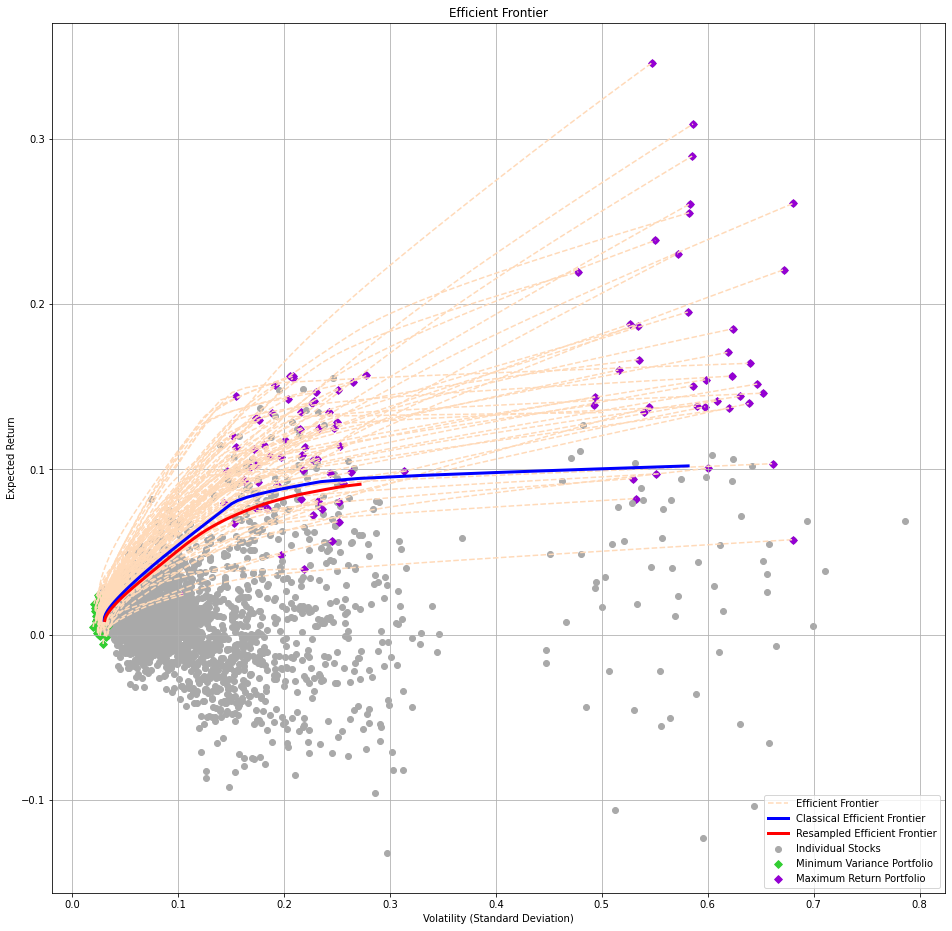

In [57]:
axC = plt.gca()
plt.rcParams['figure.figsize'] = [20, 20]

for i in range(repetition):
    # Plot volatility versus expected return for individual stocks
    axC.scatter(x=np.sqrt(np.diag(Q_resample_list[i])), y=mu_resample_list[i], color='darkgray', label='Individual Stocks' if i == 0 else "")
    
    # Plot volatility versus expected return for mimimum variance portfolio
    axC.scatter(x=np.sqrt(var_minVar_list[i]), y=ret_minVar_list[i], marker='D', s=30,  color='limegreen', label='Minimum Variance Portfolio' if i == 0 else "")

    # Plot volatility versus expected return for maximum return portfolio
    axC.scatter(x=np.sqrt(var_maxRet_list[i]), y=ret_maxRet_list[i],  marker='D', s=30, color='darkviolet', label='Maximum Return Portfolio' if i == 0 else "")

    # Plot efficient frontier
    axC.plot(np.sqrt(var_frontC_list[i]), ret_frontC_list[i], '--', color='peachpuff', label='Efficient Frontier' if i == 0 else "")

#Plot the classical mean-variance efficient frontier
axC.plot(np.sqrt(var_front_clas), ret_front_clas, color='blue', linewidth=3, label='Classical Efficient Frontier')

#Plot the resampled efficient frontier
axC.plot(np.sqrt(var_front_re), ret_front_re, color='red', linewidth=3, label='Resampled Efficient Frontier')

axC.set_xlabel('Volatility (Standard Deviation)')
axC.set_ylabel('Expected Return')
plt.title('Efficient Frontier')
axC.legend(loc="lower right")
axC.grid()
plt.show()

4 Plot the portfolio compositions for classical and resampled frontiers

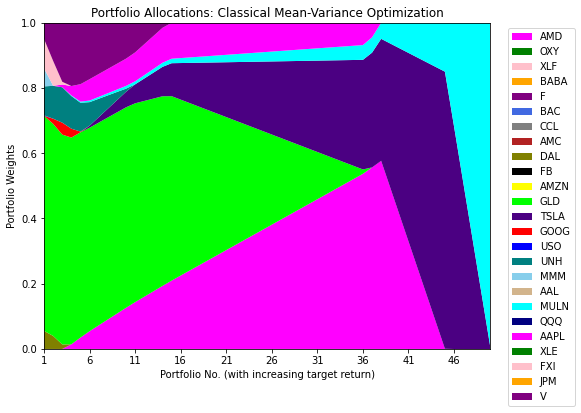

In [55]:
x_tick = np.arange(len(targetRet))+1
color_list = ['fuchsia','green','pink','orange','purple','royalblue','grey','firebrick','olive','black','yellow','lime','indigo','red','blue','teal','skyblue','tan','cyan','navy']
plt.figure(figsize=(8, 6))
plt.stackplot(x_tick, np.array(w_front_clas).T, colors=color_list)
plt.legend(df1.columns[1:], bbox_to_anchor=(1.2, 1))
plt.xlim((1,len(targetRet)))
plt.ylim((0,1))
plt.xticks(np.arange(1,len(targetRet)+1,5))
plt.xlabel("Portfolio No. (with increasing target return)")
plt.ylabel("Portfolio Weights")
plt.title("Portfolio Allocations: Classical Mean-Variance Optimization")
plt.show()

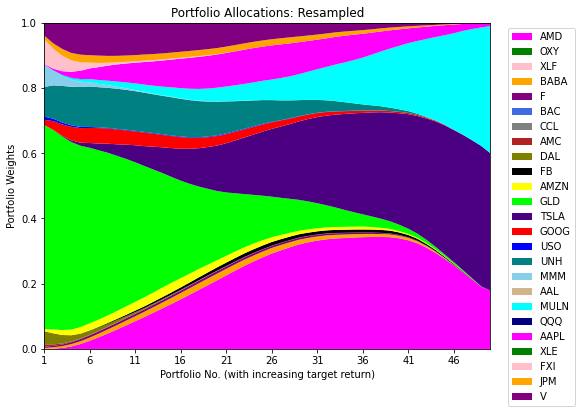

In [56]:
x_tick = np.arange(len(targetRet))+1
color_list = ['fuchsia','green','pink','orange','purple','royalblue','grey','firebrick','olive','black','yellow','lime','indigo','red','blue','teal','skyblue','tan','cyan','navy']
plt.figure(figsize=(8, 6))
plt.stackplot(x_tick, np.array(w_front_re_aver).T, colors=color_list)
plt.legend(df1.columns[1:], bbox_to_anchor=(1.2, 1))
plt.xlim((1,len(targetRet)))
plt.ylim((0,1))
plt.xticks(np.arange(1,len(targetRet)+1,5))
plt.xlabel("Portfolio No. (with increasing target return)")
plt.ylabel("Portfolio Weights")
plt.title("Portfolio Allocations: Resampled")
plt.show()
